# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ceph_path = Path.home() / 'ceph/DATA/Chromatin/DynCondPaper'



cuda


### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

# Figure 5A

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


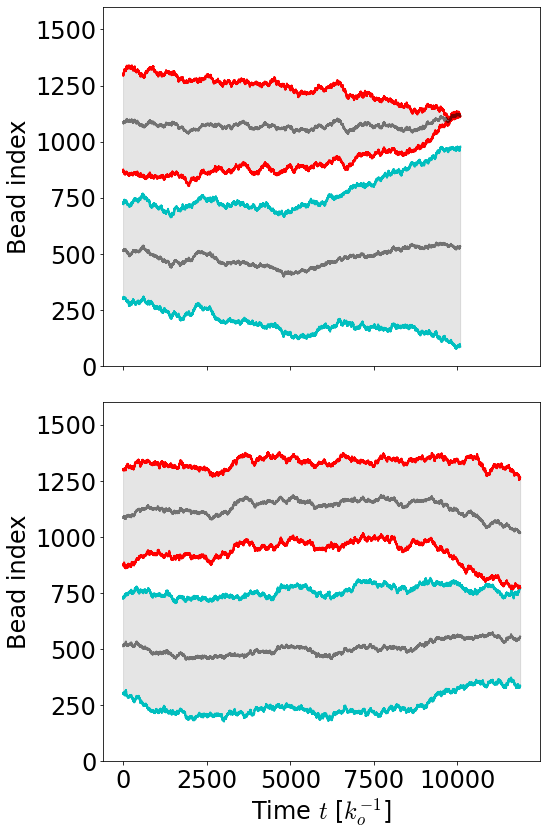

In [4]:
data_path =  next(ceph_path.glob('minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep150_L5/*.h5'))
fig, axarr = plt.subplots(2,1, figsize=(8,12), sharex=True)
with h5py.File(data_path, 'r+') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])
    # for ax, grp_name in zip(axarr, ['run_14', 'run_270']):
    for ax, grp_name in zip(axarr, ['run_270', 'run_3']):
        group_data = h5_data[grp_name]
        
        time_arr = group_data['times'][...]
        state_arr = group_data['states'][...]

        mid_point_arr = state_arr.mean(axis=-1)
        ax.set_prop_cycle(color=['c','c','r','r'])
        r_state_arr = state_arr.reshape(-1,4)
        _ = ax.plot(time_arr, r_state_arr)
        _ = ax.fill_between(time_arr, r_state_arr[:,0], r_state_arr[:,1], color='k', alpha=.1)
        _ = ax.fill_between(time_arr, r_state_arr[:,2], r_state_arr[:,3], color='k', alpha=.1)

        _ = ax.plot(time_arr, mid_point_arr, c='k', alpha=.5)
        _ = ax.set_ylabel('Bead index')
        _ = ax.set_ylim(0, 1600)
    
    _ = axarr[1].set_xlabel('Time $t$ [$k_o^{-1}$]')
fig.tight_layout()
fig.savefig('Figure5/Fig5A.png', dpi=300, bbox_inches='tight')

# Figure 5B

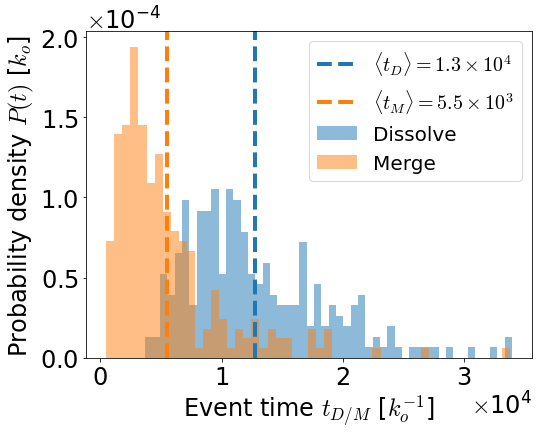

In [8]:
def convert_e_to_x10n(text):
    # Find numbers in scientific notation
    matches = re.findall(r'\b\d+\.\d+e[+-]\d+\b', text)
    for match in matches:
        # Split the number into the coefficient and the exponent
        coefficient, exponent = match.split('e')
        # Convert the number to 'x10^n' format
        x10n_format = rf"${coefficient}\times 10^{int(exponent)}$"
        # Replace the original number with the 'x10^n' format
        text = text.replace(match, x10n_format)
    return text
data_path =  next(ceph_path.glob('minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep150_L5/*.h5'))
fig, axarr = plt.subplots(1,1, figsize=(8,6), sharex=True)
with h5py.File(data_path, 'r+') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])
    dis_times = h5_data['dissolve_times'][...]
    merge_times = h5_data['merge_times'][...]
    _ = axarr.hist(dis_times, density=True, bins=50,
                     label='Dissolve',alpha=.5)
    _ = axarr.axvline(dis_times.mean(), color='tab:blue', linewidth=4, linestyle='--',
                        label=convert_e_to_x10n(rf'$\langle t_D \rangle = ${dis_times.mean():.2g}'))
    _ = axarr.hist(merge_times, density=True, bins=50,
                     label='Merge',alpha=.5)
    _ = axarr.axvline(merge_times.mean(), color='tab:orange', linewidth=4, linestyle='--',
                        label=convert_e_to_x10n(rf'$\langle t_M \rangle = ${merge_times.mean():.2g}'))
    _ = axarr.set_xlabel('Event time $t_{D/M}$ [$k_o^{-1}$]')
    _ = axarr.set_ylabel('Probability density $P(t)$ [$k_o$]')

plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))

axarr.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axarr.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

_ = axarr.legend()
fig.savefig('Figure5/Fig5C.png', dpi=300, bbox_inches='tight')




{'bead_diameter': 0.01,
 'init_state': [[296, 650], [950, 1303]],
 'kinetics': {'L': 6,
              'alpha': 0.05,
              'bd': 0.01,
              'func': 'const',
              'gamma': 0.15,
              'kappa': 0.0822,
              'ko': 1.0,
              'nu': 4.1},
 'l_sep': 300,
 'max_steps': -1,
 'n_beads': 1600,
 'system_type': 'two_blobs_free_energy'}


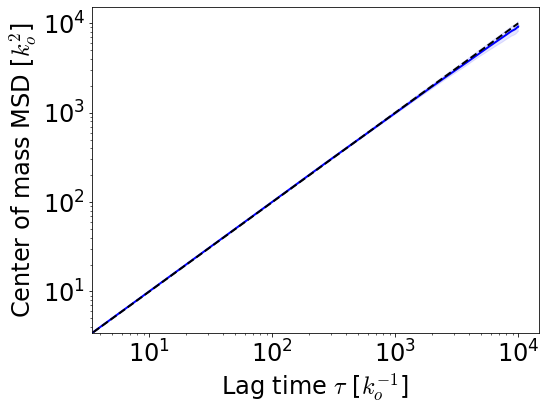

In [6]:
def condensate_msd(com_arr, device='cpu'):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    Ttot = com_arr.shape[-1]
    msd = torch.zeros(com_arr.shape, device=device)
    for i in range(1, Ttot):
        diff = tcom_arr[:,i:] - tcom_arr[:,:-i]
        msd[:,i] = torch.pow(diff,2).mean(dim=-1)

    return msd

def plot_confidence_int(ax, time_arr, mean, std_dev, num_runs=12, color='b', ci=.95, label='Mean'):
    degrees_freedom = num_runs - 1
    confidence_interval = stats.t.ppf((1 + ci) / 2., degrees_freedom) * std_dev / np.sqrt(num_runs)

    _ = ax.plot(time_arr, mean, label=label, color=color)
    _ = ax.fill_between(time_arr, mean - confidence_interval, mean + confidence_interval, color=color, alpha=.1)


data_path =  next(ceph_path.glob('minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep300_L6/*.h5'))

tmax = 10000
beta = 1.0 / 0.0041
interval = 5.


regular_time_arr = np.arange(0, tmax, interval)
com_arr_list = []
# time_arr_list = []
with h5py.File(data_path, 'r') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])
    pprint(params)

    for group in h5_data.keys():
        if 'run' not in group:
            continue

        group_data = h5_data[group]
        if tmax > group_data['times'][-1]:
            continue

        time_arr = group_data['times'][...]
        com_arr  = group_data['coms'][...]
        # time_arr_list.append(time_arr)
        # com_arr_list.append(com_arr)
        for j in [0, 1]:
            # Find the indices into a sorted array time_arr
            indices = np.searchsorted(time_arr, regular_time_arr, side='right') - 1
            # Use the indices to get the corresponding positions
            regular_positions = com_arr[indices, j]
            com_arr_list.append(regular_positions)
        

com_mat = np.vstack(com_arr_list)
msd = condensate_msd(com_mat, device=device).cpu()

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

plot_confidence_int(axarr, regular_time_arr, msd.mean(dim=0), msd.std(dim=0), num_runs=msd.shape[0], color='b', ci=.95, label='Mean')
_ = axarr.loglog(regular_time_arr, regular_time_arr, 'k--')
# _ = axarr.loglog(regular_time_arr, regular_time_arr/2., '--', c='C1')

_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')

_ = axarr.set_ylabel('Center of mass MSD [$k_o^{2}$]')
_ = axarr.set_xlabel(r'Lag time $\tau$ [$k_o^{-1}$]')
fig.savefig('Figure5/Fig5_msd_inset.png', dpi=300, bbox_inches='tight')

# Figure 5C

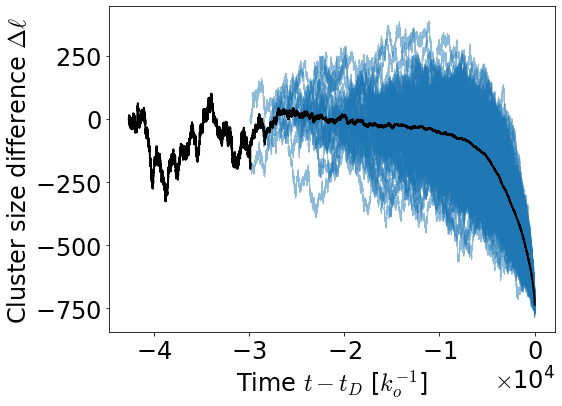

In [7]:
def mean_of_arrays(arrays):
    # Find the maximum length of the arrays
    max_length = max(arr.shape[0] for arr in arrays)

    # Create an array of np.nan values with shape (number of arrays, max length)
    padded_arrays = np.full((len(arrays), max_length), np.nan)

    # Replace the first n elements of each row with the values from the corresponding array
    for i, arr in enumerate(arrays):
        padded_arrays[i, :arr.shape[0]] = arr

    # Compute the mean along the first axis, ignoring np.nan values
    mean = np.nanmean(padded_arrays, axis=0)

    return mean

data_path =  next(ceph_path.glob('minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep300_L6/*.h5'))

tmax = 4000
beta = 1.0 / 0.0041

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

delta_l_list = []
time_arr_max = np.array([])
with h5py.File(data_path, 'r') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])

    for group in h5_data.keys():
        if 'run' not in group:
            continue
        group_data = h5_data[group]
        # if tmax > group_data['times'][-1]:
        #     continue

        last_sizes = group_data['sizes'][0, -1]
        if not(last_sizes[0] == 0 or last_sizes[1] == 0):
            continue


        delta_l = np.diff(group_data['sizes'], axis=-1)[0,:,0]
        if delta_l[-1] > 0:
            delta_l = -delta_l
        time_arr = group_data['times'][...][::-1]
        time_arr = max(time_arr) - time_arr
        if len(time_arr) > len(time_arr_max):
            time_arr_max = time_arr
        delta_l = delta_l[::-1] 
        _ = axarr.plot(-time_arr, delta_l, alpha=.5, color= 'C0', lw=1)
        delta_l_list.append(delta_l)

delta_l_mean = mean_of_arrays(delta_l_list)
_ = axarr.plot(-time_arr_max, delta_l_mean, alpha=1, color= 'k')
# _ = axarr.plot((sol.t[-1] - sol.t), (sol.y[1] - sol.y[0])/b, color="C1", label="$\Delta \ell = 0.001$")

_ = axarr.set_ylabel('Cluster size difference $\Delta \ell$')
_ = axarr.set_xlabel('Time $t-t_{D}$ [$k_o^{-1}$]')

plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
axarr.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

fig.savefig('Figure5/Fig5B.png', dpi=300, bbox_inches='tight')

## Figure 5D

/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep150_L4/lsep150_L4.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep350_L5/lsep350_L5.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep250_L5/lsep250_L5.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep200_L4/lsep200_L4.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep350_L7/lsep350_L7.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep350_L3/lsep350_L3.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-03-2

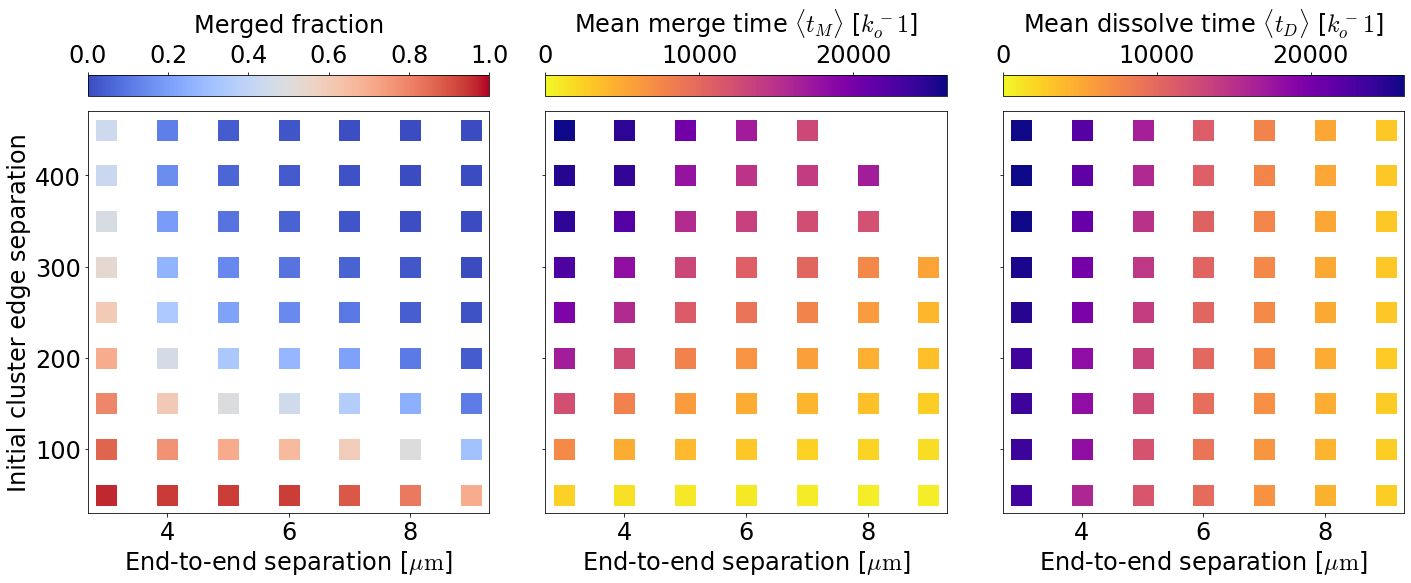

In [185]:
ss_ind = 0
end_ind = 4000
start_bead = 0
end_bead = -1

mean_lt = []
merge_mean = []
dis_mean = []
var_params = []
merge_frac = []
dis_frac = []
fig, axarr = plt.subplots(1,3, figsize=(20,8), sharey=True, sharex=True)
for ax in axarr:
    ax.set_box_aspect(1)

for h5_file in ceph_path.glob('minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/*/*.h5'):
    print(h5_file)
    with h5py.File(h5_file, 'r') as h5_data:
        params = yaml.safe_load(h5_data.attrs['params'])
        edge_sep = params['init_state'][1][0] - params['init_state'][0][1]
        var_params += [[params['kinetics']['L'], edge_sep]]
        merge_mean += [h5_data.attrs['merge_mean_lifetime']]
        dis_mean += [h5_data.attrs['dissolve_mean_lifetime']]
        mean_lt += [h5_data.attrs['mean_lifetime']]
        merge_frac += [h5_data.attrs['merge_frac']]
        dis_frac += [h5_data.attrs['dissolve_frac']]

# Masking to avoid plotting infinities
var_params = np.array(var_params)
print(var_params)

merge_mean = np.array(merge_mean)
merge_mask = np.isfinite(merge_mean) & (merge_mean != 0)


merge_var_params = var_params[merge_mask,:]
merge_mean_mask = merge_mean[merge_mask]

dis_mean = np.array(dis_mean)
print(dis_mean)
dis_mask = np.isfinite(dis_mean) #& (dis_mean != 0)

dis_var_params = var_params[dis_mask,:]
dis_mean_mask = dis_mean[dis_mask]


plot_params = {'s':400, 'marker':'s'}

# Make sure colorbars have same range
max_color_bar = max(np.max(merge_mean),np.max(dis_mean))

# Scatter plot
_ = axarr[0].scatter(var_params[:,0], var_params[:,1], c=mpl.cm.coolwarm(merge_frac), **plot_params, )
cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.03)
_ = axarr[1].scatter(merge_var_params[:,0], merge_var_params[:,1], c=mpl.cm.plasma_r(merge_mean_mask/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr[1]).append_axes("top", size="5%", pad=0.03)
_ = axarr[2].scatter(dis_var_params[:,0], dis_var_params[:,1], c=mpl.cm.plasma_r(dis_mean_mask/max_color_bar), **plot_params)
cax2 = make_axes_locatable(axarr[2]).append_axes("top", size="5%", pad=0.03)

# Color bars
cb0 = fig.colorbar(mpl.cm.ScalarMappable(cmap='coolwarm'), cax = cax0, orientation='horizontal', pad=0.2, label='Merged fraction', )
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.set_label_position('top')

cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.2, label=rf'Mean merge time $\langle t_M \rangle$ [$k_o^{-1}$]', )
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax2, orientation='horizontal', pad=0.2, label=rf'Mean dissolve time $\langle t_D \rangle$ [$k_o^{-1}$]', )
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.xaxis.set_label_position('top')
# cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[1])
# cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[2])


# _ = cb0.set_label('Merge fraction', fontsize=22)
# _ = cb2.set_label('Mean time to event', fontsize=22)
_ = axarr[0].set_ylabel('Initial condensate \n edge separation')

for ax in axarr: 
    _ = ax.set_xlabel('Chain end separation $L$')

# Append axes to the right of ax, with 5% width of ax
# cax0 = divider.append_axes("top", size="5%", pad=0.05)
_ = axarr[1].scatter(merge_var_params[:,0], merge_var_params[:,1], c=mpl.cm.plasma_r(merge_mean_mask/np.max(merge_mean_mask)), **plot_params)
_ = axarr[2].scatter(dis_var_params[:,0], dis_var_params[:,1], c=mpl.cm.plasma_r(dis_mean_mask/np.max(dis_mean_mask)), **plot_params)

# cb0 = fig.colorbar(mpl.cm.ScalarMappable(cmap='coolwarm'), ax=axarr[0])
# cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[1])
# cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[2])


# _ = cb0.set_label('Merge fraction', fontsize=22)
# _ = cb2.set_label('Mean time to event', fontsize=22)
_ = axarr[0].set_ylabel('Initial cluster edge separation')


for ax in axarr: 
    _ = ax.set_xlabel(r'End-to-end separation [$\mu {\rm m}$]')

fig.tight_layout()

cb0.ax.xaxis.set_label_coords(0.5,3.)
cb1.ax.xaxis.set_label_coords(0.5,3.)
cb2.ax.xaxis.set_label_coords(0.5,3.)
fig.savefig('Figure5/merge_frac_lifetime.png', dpi=600, bbox_inches='tight')

## Difference in condensate size

/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-04-04_Renger1600_slice9.7.1_sep100_dl0-200_L3-9um/simulations/dl200_L8/dl200_L8.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-04-04_Renger1600_slice9.7.1_sep100_dl0-200_L3-9um/simulations/dl2_L6/dl2_L6.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-04-04_Renger1600_slice9.7.1_sep100_dl0-200_L3-9um/simulations/dl10_L8/dl10_L8.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-04-04_Renger1600_slice9.7.1_sep100_dl0-200_L3-9um/simulations/dl100_L4/dl100_L4.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-04-04_Renger1600_slice9.7.1_sep100_dl0-200_L3-9um/simulations/dl1_L7/dl1_L7.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-04-04_Renger1600_slice9.7.1_sep100_dl0-200_L3-9um/simulations/dl200_L4/dl200_L4.h5
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/minimal_cond_runs/24-04-04_Re

(0.5, 500)

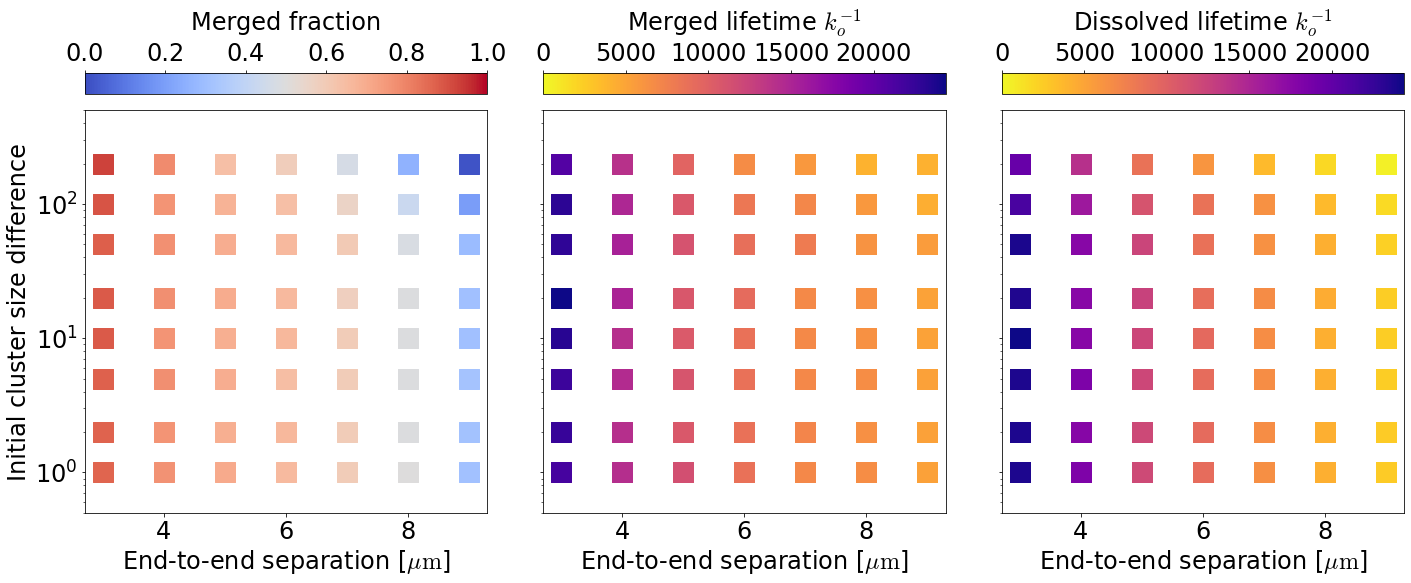

In [8]:
ss_ind = 0
end_ind = 4000
start_bead = 0
end_bead = -1

mean_lt = []
merge_mean = []
dis_mean = []
var_params = []
merge_frac = []
dis_frac = []
fig, axarr = plt.subplots(1,3, figsize=(20,8), sharey=True, sharex=True)
for ax in axarr:
    ax.set_box_aspect(1)

for h5_file in ceph_path.glob('DynCondPaper/minimal_cond_runs/24-04-04_Renger1600_slice9.7.1_sep100_dl0-200_L3-9um/simulations/*/*.h5'):
    print(h5_file)
    with h5py.File(h5_file, 'r+') as h5_data:
        params = yaml.safe_load(h5_data.attrs['params'])
        # edge_sep = params['init_state'][1][0] - params['init_state'][0][1]
        var_params += [[params['kinetics']['L'], params['dl']]]
        merge_mean += [h5_data.attrs['merge_mean_lifetime']]
        dis_mean += [h5_data.attrs['dissolve_mean_lifetime']]
        mean_lt += [h5_data.attrs['mean_lifetime']]
        merge_frac += [h5_data.attrs['merge_frac']]
        dis_frac += [h5_data.attrs['dissolve_frac']]

# Masking to avoid plotting infinities
var_params = np.array(var_params)

merge_mean = np.array(merge_mean)
merge_mask = np.isfinite(merge_mean) & (merge_mean != 0)


merge_var_params = var_params[merge_mask,:]
merge_mean_mask = merge_mean[merge_mask]

dis_mean = np.array(dis_mean)
print(dis_mean)
dis_mask = np.isfinite(dis_mean) #& (dis_mean != 0)

dis_var_params = var_params[dis_mask,:]
dis_mean_mask = dis_mean[dis_mask]


plot_params = {'s':400, 'marker':'s'}

# Make sure colorbars have same range
max_color_bar = max(np.max(merge_mean),np.max(dis_mean))


# Scatter plot
_ = axarr[0].scatter(var_params[:,0], var_params[:,1], c=mpl.cm.coolwarm(merge_frac), **plot_params, )
cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.03)
_ = axarr[1].scatter(merge_var_params[:,0], merge_var_params[:,1], c=mpl.cm.plasma_r(merge_mean_mask/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr[1]).append_axes("top", size="5%", pad=0.03)
_ = axarr[2].scatter(dis_var_params[:,0], dis_var_params[:,1], c=mpl.cm.plasma_r(dis_mean_mask/max_color_bar), **plot_params)
cax2 = make_axes_locatable(axarr[2]).append_axes("top", size="5%", pad=0.03)

# Color bars
cb0 = fig.colorbar(mpl.cm.ScalarMappable(cmap='coolwarm'), cax = cax0, orientation='horizontal', pad=0.2, label='Merged fraction', )
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.set_label_position('top')

cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.2, label='Merged lifetime $k_o^{-1}$', )
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax2, orientation='horizontal', pad=0.2, label='Dissolved lifetime $k_o^{-1}$', )
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.xaxis.set_label_position('top')
# cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[1])
# cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[2])


# _ = cb0.set_label('Merge fraction', fontsize=22)
# _ = cb2.set_label('Mean time to event', fontsize=22)
_ = axarr[0].set_ylabel('Initial condensate \n edge separation')


# Append axes to the right of ax, with 5% width of ax
# cax0 = divider.append_axes("top", size="5%", pad=0.05)
_ = axarr[1].scatter(merge_var_params[:,0], merge_var_params[:,1], c=mpl.cm.plasma_r(merge_mean_mask/np.max(merge_mean_mask)), **plot_params)
_ = axarr[2].scatter(dis_var_params[:,0], dis_var_params[:,1], c=mpl.cm.plasma_r(dis_mean_mask/np.max(dis_mean_mask)), **plot_params)

# cb0 = fig.colorbar(mpl.cm.ScalarMappable(cmap='coolwarm'), ax=axarr[0])
# cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[1])
# cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[2])


# _ = cb0.set_label('Merge fraction', fontsize=22)
# _ = cb2.set_label('Mean time to event', fontsize=22)
_ = axarr[0].set_ylabel('Initial cluster size difference')


for ax in axarr: 
    _ = ax.set_xlabel(r'End-to-end separation [$\mu {\rm m}$]')

axarr[0].set_yscale('log')
axarr[0].set_ylim(.5, 500)

fig.tight_layout()


cb0.ax.xaxis.set_label_coords(0.5,3.)
cb1.ax.xaxis.set_label_coords(0.5,3.)
cb2.ax.xaxis.set_label_coords(0.5,3.)
fig.savefig('Figure5/merge_frac_lifetime_dl_L.png', dpi=600, bbox_inches='tight')

## Single testing

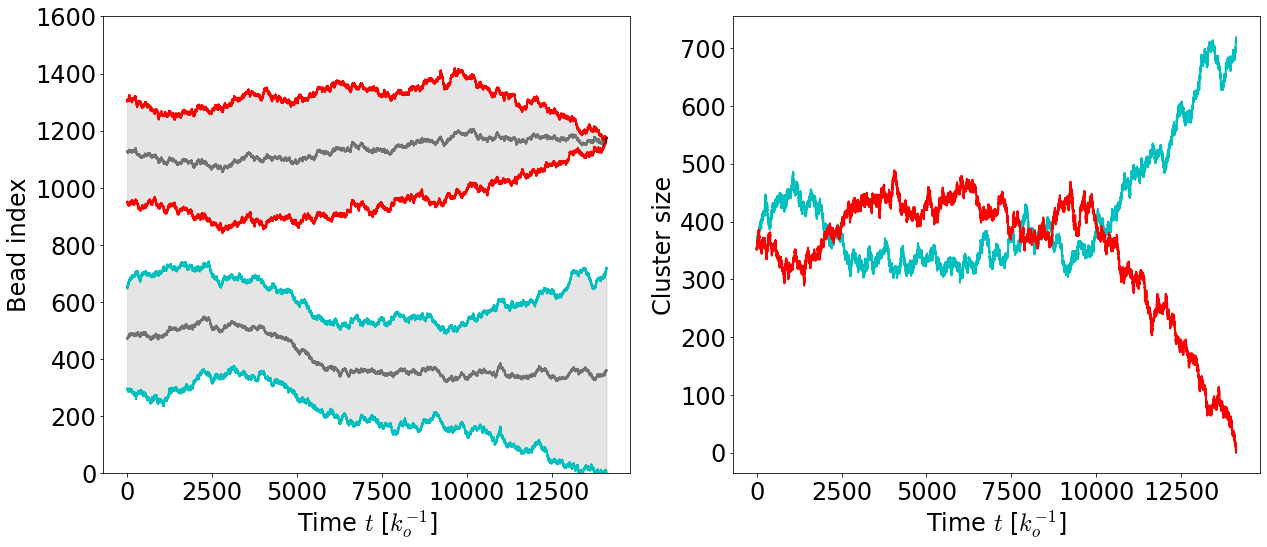

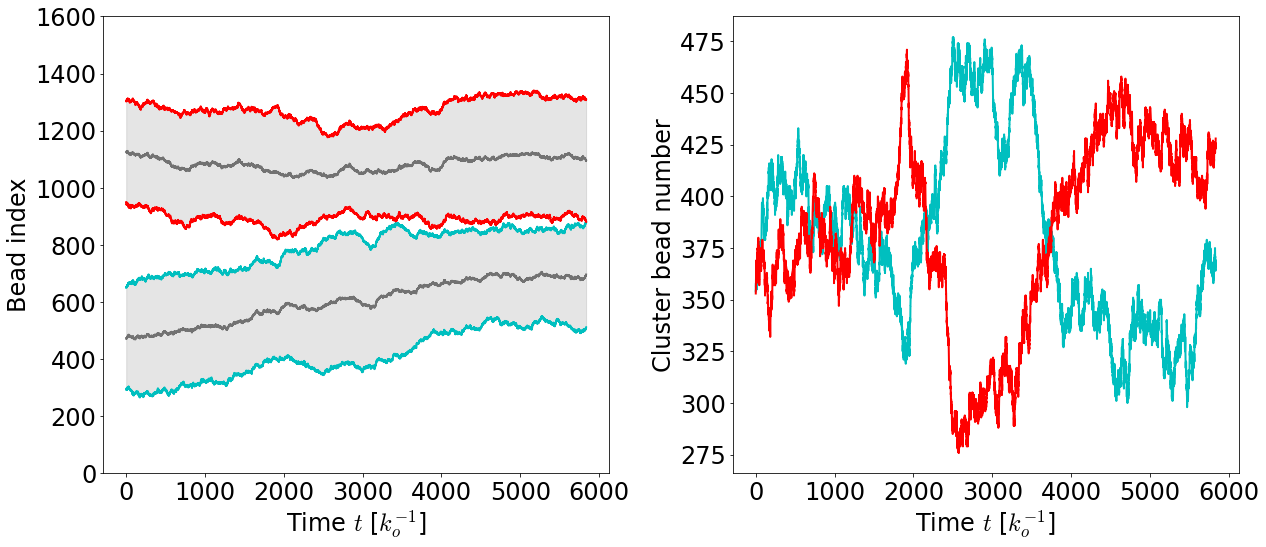

In [83]:
data_path =  next(ceph_path.glob('minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep300_L6/*.h5'))
with h5py.File(data_path, 'r+') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])
    group_data = h5_data['run_1']
    
    time_arr = group_data['times'][...]
    state_arr = group_data['states'][...]

mid_point_arr = state_arr.mean(axis=-1)
fig, axarr = plt.subplots(1,2, figsize=(18,8))
axarr[0].set_prop_cycle(color=['c','c','r','r'])
axarr[1].set_prop_cycle(color=['c','r'])
r_state_arr = state_arr.reshape(-1,4)
_ = axarr[0].plot(time_arr, r_state_arr)
_ = axarr[0].fill_between(time_arr, r_state_arr[:,0], r_state_arr[:,1], color='k', alpha=.1)
_ = axarr[0].fill_between(time_arr, r_state_arr[:,2], r_state_arr[:,3], color='k', alpha=.1)
#axarr[0].set_prop_cycle(cyc)
#cyc = cycler(color=['c','m'])

_ = axarr[0].plot(time_arr, mid_point_arr, c='k', alpha=.5)
_ = axarr[0].set_xlabel('Time')
_ = axarr[0].set_ylabel('Bead index')
_ = axarr[0].set_ylim(0, 1600)
_ = axarr[1].set_xlabel('Time $t$ [$k_o^{-1}$]')
_ = axarr[1].set_ylabel('Cluster size')
_ = axarr[1].plot(time_arr, np.diff(state_arr, axis=-1).reshape(-1,2))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ [$k_o^{-1}$]')
    
fig.tight_layout()
data_path =  next(ceph_path.glob('minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep300_L6/*.h5'))
with h5py.File(data_path, 'r+') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])
    group_data = h5_data['run_10']
    
    time_arr = group_data['times'][...]
    state_arr = group_data['states'][...]

mid_point_arr = state_arr.mean(axis=-1)
fig, axarr = plt.subplots(1,2, figsize=(18,8))
axarr[0].set_prop_cycle(color=['c','c','r','r'])
axarr[1].set_prop_cycle(color=['c','r'])
r_state_arr = state_arr.reshape(-1,4)
_ = axarr[0].plot(time_arr, r_state_arr)
_ = axarr[0].fill_between(time_arr, r_state_arr[:,0], r_state_arr[:,1], color='k', alpha=.1)
_ = axarr[0].fill_between(time_arr, r_state_arr[:,2], r_state_arr[:,3], color='k', alpha=.1)
#axarr[0].set_prop_cycle(cyc)
#cyc = cycler(color=['c','m'])

_ = axarr[0].plot(time_arr, mid_point_arr, c='k', alpha=.5)
_ = axarr[0].set_ylabel('Bead index')
_ = axarr[0].set_ylim(0, 1600)
_ = axarr[1].set_ylabel('Cluster bead number')
_ = axarr[1].plot(time_arr, np.diff(state_arr, axis=-1).reshape(-1,2))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ [$k_o^{-1}$]')
    
fig.tight_layout()